In [2]:
%load_ext autoreload
%autoreload 2

# 1. 病种高套（BZGY）基本建模思路
  
* 病种高套指在DRGs或者单病种付费支付制度下，医院高编病组,套取超额报销的违规行为。
  
<p>住院结束后医院需要把入院诊断，出院诊断和每日使用明细和花费上传给医保局. 医院可以轻易修改出院诊断，但每日明细耗材涉及到药品进销存等，不易篡改。因为我们可以使用大量住院单据，训练从明细->出院诊断的分类模型。对于每个住院单据，我们使用分类模型判断其出院诊断，如果模型输出和实际商保诊断不符，且模型推断的诊断对应报销金额大于医院实际上报诊断时，则该单据有较大的病种高套嫌疑</p>
  
  

 

  
  

# 2. ULMFIT 迁移学习模型

#### Universal Language Model Fine-tuning for Text Classification
https://arxiv.org/abs/1801.06146

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [58]:
#load

# pick ICDs with enough sample
import pyspark.sql.functions as pyspark_F
from tqdm import tqdm


from fastai import *
from fastai.text import *
from pyspark import SparkConf
from pyspark.sql import SparkSession

from pyspark.sql.functions import pandas_udf,PandasUDFType,concat_ws,collect_list
from pyspark.sql.types import *

# spark.stop()
conf = SparkConf().setAppName('BZGT').setMaster('local[*]')
spark = SparkSession.builder.config(conf=conf).config("spark.driver.memory", "35g").config("spark.local.dir", "/media/data1/data/tmp").getOrCreate()
spark

## 4.1 在全量单据上训练语言模型

In [2]:
# 全量数据！！！

# DETAIL_PATH_FULL = "./data/1month/detail"

# detail_full = spark.read.parquet(DETAIL_PATH_FULL).union(spark.read.parquet(DETAIL_PATH_INHOSP))

# print(detail_full.count())


In [5]:
#load
DETAIL_PATH_INHOSP = "./data/inHosp/detail"

detail_full = spark.read.parquet(DETAIL_PATH_INHOSP)
data_full = detail_full.select(["REGISTER_NO","MED_PROJECT_NAME"]).groupby("REGISTER_NO").agg(concat_ws(",", collect_list("MED_PROJECT_NAME")).alias("details"))
# 小数据
# data = data

In [6]:
#load

data = data_full.toPandas()

REGISTER_PATH = "./data/inHosp/register"
DETAIL_PATH = "./data/inHosp/detail"
COMBINED_PATH = "./data/inHosp/combined"

#从医保报销的单据表中抽取住院单据以及其对应明细清单
register = spark.read.parquet(REGISTER_PATH)
detail = spark.read.parquet(DETAIL_PATH)
combine = spark.read.parquet(COMBINED_PATH)
print(register.count())
print(detail.count())
print(combine.count())

### filter out diseases with few samples

min_sample = 200

icd_diagnosis = \
register.select(['out_hosp_diagnosisname','out_hosp_diagnosiscode']).dropna().\
filter(pyspark_F.length("out_hosp_diagnosiscode")>=5).\
withColumn("ICD4", register.out_hosp_diagnosiscode.substr(0,5)).\
groupby(['out_hosp_diagnosisname','ICD4']).count().\
filter(f"count >= {min_sample}").\
sort(["out_hosp_diagnosisname",]).collect()

icd_diagnosis_dict = {}
for row in icd_diagnosis:
    icd_diagnosis_dict[row.ICD4] = row.out_hosp_diagnosisname
len(icd_diagnosis_dict)

data_inhosp = \
combine.filter(pyspark_F.length("out_hosp_diagnosiscode")>=5).\
withColumn("ICD4", combine.out_hosp_diagnosiscode.substr(0,5)).\
filter(pyspark_F.col('ICD4').isin(list(icd_diagnosis_dict.keys()))).toPandas()
data_inhosp

139229
44195071
136118


register_no      per_no  age sex per_type   zone_name  \
0            219762348-1-330522012  f91c34b573   36   女     城镇职工  c7cdeaff4b   
1            219762549-1-330522012  fe114e1d78   56   男     城镇职工  c7cdeaff4b   
2            219786156-1-330522012  946df375b9   56   男     城镇职工  c7cdeaff4b   
3            219851040-1-330522012  5a605afc4b   64   男     城镇居民  c7cdeaff4b   
4            219851061-1-330522012  79af746d7c   27   女     城镇居民  c7cdeaff4b   
5            219851488-1-330522012  255f7572c7   76   男     城镇居民  c7cdeaff4b   
6            219908562-1-330522012  f40f42aefa   86   男     城镇居民  c7cdeaff4b   
7            219908631-1-330522012  1df8f0475b   79   男     城镇职工  c7cdeaff4b   
8            219935082-1-330522012  ccb2835bd1   72   男     城镇职工  c7cdeaff4b   
9            219986664-1-330522012  61bf28584e   68   男     城镇职工  c7cdeaff4b   
10           220019433-1-330522012  1cdf68a1fb   63   女     城镇职工  c7cdeaff4b   
11           220048138-1-330522012  372c6b23e0   70   女     城镇职工  c7cdeaff4b   
12           220048447-1-330522012  547eb47574   73   女     城镇职工  c7cdeaff4b   
13           220048609-1-330522012  b0732d5039   44   男     城镇职工  c7cdeaff4b   
14           220048644-1-330522012  13691c6b88   26   女     城镇职工  c7cdeaff4b   
15           220078215-1-330522012  27ff511602   22   女     城镇居民  c7cdeaff4b   
16           220078364-1-330522012  45f2e26d9d   61   男     城镇居民  c7cdeaff4b   
17           220107066-1-330522012  466118801f   92   女     城镇居民  c7cdeaff4b   
18           220136204-1-330522012  cc26041e10   69   女     城镇职工  c7cdeaff4b   
19           220164305-1-330522012  c5015d8d9d   71   女     城镇职工  c7cdeaff4b   
20           220164317-1-330522012  6810494d09   68   男     城镇居民  c7cdeaff4b   
21           220164353-1-330522012  e4b593048b    8   男     城镇居民  c7cdeaff4b   
22           220189029-1-330522012  2f2504de29   58   女     城镇居民  c7cdeaff4b   
23           220189145-1-330522012  8016ba65be   69   男     城镇居民  c7cdeaff4b   
24           220189158-1-330522012  bdbd882d98   67   女     城镇居民  c7cdeaff4b   
25           220223381-1-330522012  71f01535e0    9   男     城镇居民  c7cdeaff4b   
26           220284616-1-330522012  3df3704525    1   男     城镇居民  c7cdeaff4b   
27           220284743-1-330522012  76f0e9d98c   51   男     城镇职工  c7cdeaff4b   
28           220315462-1-330522012  203def98d7   53   男     城镇居民  c7cdeaff4b   
29           220347188-1-330522012  b3a900037d   81   男     城镇职工  c7cdeaff4b   
...                            ...         ...  ...  ..      ...         ...   
84948     990934561521-1-330599012  2cf38e12ec   26   男     城镇职工  eacdb2c782   
84949  990937449841-1-330599012-27  9063ef2803   82   女     城镇居民  acd9db4c1e   
84950  990938516461-1-330599012-26  c5c0d53fbe   75   女     城镇居民  f3ab3890d4   
84951     990939496601-1-330599012  09e1eac559   49   女     城镇职工  eacdb2c782   
84952  990939696861-1-330599012-27  f2d9bdff81   61   男     城镇居民  acd9db4c1e   
84953  990941290761-1-330599012-27  2ee617f674   70   男      390  acd9db4c1e   
84954     990943251831-1-330599012  acc168d103   38   女     城镇职工  eacdb2c782   
84955  990943769411-1-330599012-26  dc941c9ba9   50   女     城镇居民  f3ab3890d4   
84956  990944268831-1-330599012-27  58d072e984   48   男     城镇居民  acd9db4c1e   
84957  990945052531-1-330599012-26  9674370bc9   63   女      390  f3ab3890d4   
84958     990945665241-1-330599012  9145569e99   78   男     城镇职工  eacdb2c782   
84959  990946110301-1-330599012-27  76a1f2557a   70   女      390  acd9db4c1e   
84960     990946617621-1-330599012  7b8e68ca7d   78   男     城镇职工  eacdb2c782   
84961  990948900931-1-330599012-27  81607363d9   61   女     城镇居民  acd9db4c1e   
84962  990949281191-1-330599012-27  3b55db8370   47   女     城镇居民  acd9db4c1e   
84963  990949904431-1-330599012-26  2ececdf6e8   34   男     城镇居民  f3ab3890d4   
84964     990951885431-1-330599012  d9c93d5f9c   47   女     城镇职工  eacdb2c782   
84965  990951904381-1-330599012-27  be248635aa   64   男     城镇居民  acd9db4c1e   
84966  990951921531-1-3

In [18]:
# load
bs=64
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(data_inhosp[['details','ICD4']],test_size=0.2)
X_train.shape

(67982, 2)

使用 Sentence Piece Encoder 来处理明细名称非标准的问题：https://github.com/google/sentencepiece

In [7]:
#load
# Fastai has a bug regarding ssp:https://forums.fast.ai/t/trouble-saving-with-sentencepiece-tokenizer/42143
def get_default_size(texts, max_vocab_sz):
    "Either max_vocab_sz or one quarter of the number of unique words in `texts`"
    cnt = Counter()
    for t in texts: 
        cnt.update(t.split())
        if len(cnt)//4 > max_vocab_sz: return max_vocab_sz
    res = len(cnt)//4
    while res%8 != 0: res+=1
    return res

def train_sentencepiece_fixed(texts:Collection[str], path:PathOrStr, pre_rules: ListRules=None, post_rules:ListRules=None, 
    vocab_sz:int=None, max_vocab_sz:int=5000, model_type:str='unigram', max_sentence_len:int=20480, lang='en',
    char_coverage=None, tmp_dir='tmp', enc='utf8'):
    "Train a sentencepiece tokenizer on `texts` and save it in `path/tmp_dir`"
    from sentencepiece import SentencePieceTrainer
    cache_dir = Path(path)/tmp_dir
    os.makedirs(cache_dir, exist_ok=True)
    if vocab_sz is None: vocab_sz=get_default_size(texts, max_vocab_sz)
    raw_text_path = cache_dir / 'all_text.out'
    with open(raw_text_path, 'w', encoding=enc) as f: f.write("\n".join(texts))
    spec_tokens = ['\u2581'+s for s in defaults.text_spec_tok]
    SentencePieceTrainer.Train(" ".join([
        f"--input={raw_text_path} --max_sentence_length={max_sentence_len}",
        f"--character_coverage=0.9998",
        f"--unk_id={len(defaults.text_spec_tok)} --pad_id=-1 --bos_id=-1 --eos_id=-1",
        f"--user_defined_symbols={','.join(spec_tokens)}",
        f"--model_prefix={cache_dir/'spm'} --vocab_size={vocab_sz} --model_type={model_type}"]))
    raw_text_path.unlink()
    return cache_dir

class FixSSP(SPProcessor):
     def __init__(self,pre_rules: ListRules=None, post_rules:ListRules=None, vocab_sz:int=None,
                 max_vocab_sz:int=5000, model_type:str='unigram', max_sentence_len:int=20480, lang='cn',
                 char_coverage=None, tmp_dir='tmp', mark_fields:bool=False, include_bos:bool=True, 
                 include_eos:bool=False,  enc='utf8', **kwargs):
            super().__init__(**kwargs)
            self.train_func = partial(train_sentencepiece_fixed, pre_rules=pre_rules, post_rules=post_rules, vocab_sz=vocab_sz,
                max_vocab_sz=max_vocab_sz, model_type=model_type, max_sentence_len=max_sentence_len, lang=lang,
                char_coverage=char_coverage, tmp_dir=tmp_dir, enc=enc)
            
            

In [6]:
# from sentencepiece import SentencePieceProcessor
# tok = SentencePieceProcessor()
# tok.load("./tmp/spm.model")

# tok.encode_as_pieces("穿刺组织活断,尿素氮测定（急诊）,山药（配方颗粒）,静脉穿刺置管术,视黄醇结合蛋白")

## 创建语言模型

In [20]:
# train
bs=128
databunch = (TextList.from_df(data,cols="details", processor=[FixSSP(max_vocab_sz=5000)])
             .split_by_rand_pct(0.1, seed=42)
             .label_for_lm()
             .databunch(bs=bs,num_workers=1))


In [22]:
# len(databunch.vocab.itos)

5000

In [24]:
# train

learn = language_model_learner(databunch, AWD_LSTM, drop_mult=0.1, wd=0.1, pretrained=False).to_fp16()
lr = 3e-3
lr *= bs/48  # Scale learning rate by batch size

In [25]:
# train

import warnings
warnings.filterwarnings('ignore')

learn.unfreeze()
learn.fit_one_cycle(1, lr, moms=(0.8,0.7))

In [26]:
# train

lm_fns = ['./lm_wt', './lm_wt_vocab']
learn.to_fp32().save(lm_fns[0], with_opt=False)
learn.data.vocab.save(lm_fns[1])

## 4.2 在（drgs）住院单据上精调语言模型-Domain Fine Tune

In [66]:
# train

bs=64

data_fine_tuned = (TextList.from_df(data_inhosp,cols="details", processor=[FixSSP.load("./")])
             .split_by_rand_pct(0.1, seed=42)
             .label_for_lm()
             .databunch(bs=bs,bptt=50,num_workers=1))

In [67]:
# train

lm_fns = ['./lm_wt', './lm_wt_vocab']

learn_lm = language_model_learner(data_fine_tuned, AWD_LSTM, pretrained_fnames=lm_fns, drop_mult=1.0, wd=0.1)

In [71]:
# train

lr = 1e-3
lr *= bs/48

learn_lm.to_fp16().fit_one_cycle(1, lr*10, moms=(0.8,0.7))

In [80]:
# train

learn_lm.unfreeze()
learn_lm.to_fp16().fit_one_cycle(1, slice(lr/10,lr*10), moms=(0.8,0.7))

In [82]:
# train

learn_lm.save(f'lm_fine_tuned')
learn_lm.save_encoder(f'lm_fine_tuned_enc')

In [83]:
# train
# learn_lm.load_encoder(f'lm_fine_tuned')
learn_lm.export("./lm_finetuned.pkl")

### 检测语言模型

In [34]:
# train

def generate(prefix, predict_func, n_words=500, temp=1):
    out = [i for i in predict_func(
        prefix, n_words, temperature=temp).split(" ")]
    return "   ".join(out)

TEXT = "胰岛素"
predict_func = functools.partial(learn_lm.predict)
# AWD_learn.beam_search
generate(TEXT,predict_func=predict_func)

'胰岛素   专用   注射器   (   注射针头   ),   一次性密闭输液针   ,   一般专项护理   ,   钠测定   (   急诊   ),   血清丙氨酸氨基转移酶测定   (   急诊   ),   血氧饱和度监测   ,   氧气雾化吸入   ,   持续呼吸功能监测   ,   氯化钠   ,   托拉塞米   ,   一次性注射器   ,   肌肉注射   ,   一次性注射器   ,   一次性真空采血器   ,   血清总胆固醇测定   ,   动脉采血   ,   血   常规   (   五   分类   ),   普通病房床位费   ,   氯化钾   ,   血清直接胆红素测定   ,   血清天门冬氨酸氨基转移酶测定   ,   氯化钾   ,   呋塞米   ,   血清肌钙蛋白   i   测定   ,   血清总胆汁酸测定   ,   尿素氮测定   (   急诊   ),   血清胆碱脂酶测定   ,   抗   p   m   -   sc   i   抗体测定   ,   血清肌红蛋白测定   ,   静脉注射   ,   一次性留置针   ,   呋塞米   ,   头孢哌酮舒巴坦   ,   抗   甲状腺球蛋白   抗体测定   (   t   ga   b   ),   血清天门冬氨酸氨基转移酶测定   ,   特布他林   ,   丙型肝炎抗体   (   igm   )   测定   ,   氯硝西泮   ,   血清尿酸测定   ,   免疫球蛋白   igm   定量测定   ,   住院   诊   查   费   (   三   级   医院   ),   氨溴索   ,   一般专项护理   ,   乙酰半胱氨酸   ,   钙测定   ,   艾迪注射液   ,   一次性密闭输液针   ,   钙测定   (   急诊   ),   凝血酶   时间测定   (   t   t   ),   细胞   角蛋白   19   片   段   测定   (   c   y   fr   a   21-1),   米力农   ▁米力农氯化钠   ▁米力农葡萄糖   ,   一次性过滤器   ,   氨甲环酸   ,   血   常规   (   五   分类   ),   重组人脑利钠肽   

## 4.3 将语言模型的RNN编码器迁移到下游分类

In [97]:
# train

data_clas = (TextList.from_df(X_train, cols='details', processor=FixSSP.load("./"))
    .split_by_rand_pct(0.1, seed=42)
    .label_from_df(cols='ICD4')
    .add_test(X_test.details)
    .databunch(bs=bs, num_workers=1))

In [ ]:
#train
# data_clas.save(f'clas_databunch')

In [10]:
#train
data_clas = load_data(".", f'clas_databunch', bs=64)
learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, pretrained=False, wd=0.1)

In [9]:
#train

# set train param
bs = 64
lr=2e-2
lr *= bs/48

In [12]:
# train
# only train classifier head

learn_c.load_encoder(f'lm_fine_tuned_enc')
learn_c.freeze()
learn_c.to_fp16()
learn_c.fit_one_cycle(1, lr, moms=(0.8,0.7))

In [ ]:
#train
# train full network with discriminate rate
import warnings
warnings.filterwarnings('ignore')
learn_c.unfreeze()

In [ ]:
learn_c.to_fp16().fit_one_cycle(4, slice(lr/10/(2.6**4),lr/10), moms=(0.8,0.7))

In [13]:
learn_c.to_fp32().save("classifier_finetuned")

In [15]:
#train
# learn_c.load("classifier_finetuned")
learn_c.to_fp32().export()

## 4.4 推理

In [41]:
# infer
classifier = load_learner(".")

In [47]:
def pred_batch(X_test,model = classifier):
    
    cls = model.data.y.classes
    preds = []
    for i in tqdm(range(len(X_test))):
        text = X_test.iloc[i].details
        preds.append(cls[model.predict(text)[1].data.item()])
    return preds



In [48]:
preds = pred_batch(X_test[:5000])


  6%|▋         | 323/5000 [00:23<05:38, 13.83it/s]


 13%|█▎        | 640/5000 [00:46<05:05, 14.28it/s]


 19%|█▉        | 965/5000 [01:08<04:29, 14.97it/s]


 26%|██▌       | 1295/5000 [01:31<04:09, 14.84it/s]


 32%|███▏      | 1620/5000 [01:52<03:46, 14.92it/s]


 39%|███▉      | 1944/5000 [02:15<03:49, 13.33it/s]


 45%|████▌     | 2253/5000 [02:37<03:42, 12.32it/s]


 51%|█████▏    | 2567/5000 [03:00<03:21, 12.05it/s]


 58%|█████▊    | 2886/5000 [03:23<02:18, 15.25it/s]


 64%|██████▍   | 3202/5000 [03:46<02:03, 14.60it/s]


 70%|███████   | 3516/5000 [04:08<01:52, 13.16it/s]


 77%|███████▋  | 3839/5000 [04:31<01:12, 15.96it/s]


 83%|████████▎ | 4164/5000 [04:54<00:51, 16.33it/s]


 90%|████████▉ | 4483/5000 [05:16<00:41, 12.37it/s]


 96%|█████████▌| 4806/5000 [05:39<00:12, 15.53it/s]


100%|██████████| 5000/5000 [05:53<00:00, 14.14it/s]


In [49]:
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix

print(classification_report(X_test[:5000].ICD4, preds))

              precision    recall  f1-score   support

       A41.9       0.45      0.42      0.43        12
       B99.x       0.60      0.48      0.53        25
       C15.9       0.00      0.00      0.00        19
       C16.9       0.56      0.54      0.55        41
       C18.9       0.75      0.58      0.66        36
       C20.x       0.58      0.46      0.51        24
       C22.9       0.62      0.25      0.36        20
       C34.9       0.64      0.72      0.68       116
       C50.9       0.82      0.82      0.82        67
       C61.x       0.88      0.50      0.64        14
       C73.x       0.87      0.83      0.85        24
       C85.9       0.88      0.61      0.72        23
       C90.0       0.91      0.87      0.89        23
       D17.9       0.71      0.60      0.65        20
       D24.x       0.56      0.75      0.64        12
       D25.9       0.77      0.77      0.77        22
       E04.1       0.94      0.94      0.94        34
       E11.9       0.82    

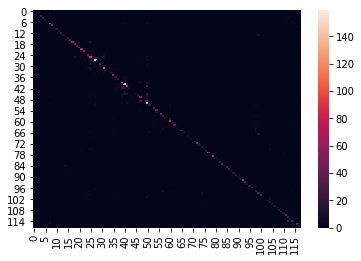

In [50]:
import seaborn as sn

sn.heatmap(confusion_matrix(X_test[:5000].ICD4, preds))

## 4.5 数据可视化

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
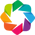

In [84]:
from wordcloud import WordCloud, STOPWORDS
import panel as pn
import hvplot.pandas  # noqa: API import
import holoviews as hv

from holoviews.streams import Selection1D
import matplotlib.pyplot as plt
from skimage.io import imshow, imread
import jieba
import umap

jieba.enable_parallel(4)
pn.extension()
hv.extension("bokeh")

In [85]:
def get_encoding(details,
                model=learn_c):
    encoder = model.model[0]
    out = []
    for i in tqdm(range(len(details)), position=0, leave=True):
        encoder.reset()
        xb, yb = model.data.one_item(details[i])
        with torch.no_grad():
            encoded = encoder.eval()(xb)
#             pdb.set_trace()
            out.append(encoded[0][-1][0][-1].detach())
#     pdb.set_trace()
    res = torch.stack(out, dim=0)
    return res

In [88]:
classifier = load_learner(".")
lm = load_learner(".","lm_finetuned.pkl")

In [89]:
sample = X_train.sample(3000)
classifier_encoding = get_encoding(list(sample.details), model = classifier)
lm_encoding = get_encoding(list(sample.details), model = lm)

100%|██████████| 3000/3000 [01:49<00:00, 27.45it/s]


In [90]:
sample

details   ICD4
1052   常规心电图检查,眼科常规检查,乙肝三系检查,日常生活能力评定,血清碳酸氢盐(HCO3)测定,...  H11.0
39974  计算机图文报告,等级护理（三级医院）,吉非替尼,乳酸脱氢酶测定,一次性真空采血器,血清总蛋白...  C34.9
69252  血氧饱和度监测,普通病房床位费,特级护理,氯化钠,心电监护,鼻导管吸氧,静脉置管冲洗,结核菌...  I67.9
44226  [复方]聚乙二醇电解质,右美托咪定,血氧饱和度监测,住院诊查费（三级医院),一般专项护理,皮...  N40.x
9892   钙测定,血清白蛋白测定,冬瓜子（配方颗粒）,血清间接胆红素测定,静脉输液（住院/含输液器）,...  J15.9
15363                                                     syjtb
73388  血清肌酸激酶－MB同工酶活性测定,静脉采血,氯化钾,钠测定,住院诊查费（二级医院),卡式配血...  N83.2
47648  省、市离休住院可使用的诊疗项目,血氧饱和度监测,尿素氮测定,鼻导管吸氧,一般专项护理,一次性...  K37.x
81307  省、市离休住院可使用的一次性材料,螺旋CT平扫（一个部位）,心电监护,血清铁蛋白测定,抗线粒...  I10.x
28976  省、市离休门诊、住院可使用的诊疗项目,肾功能常规检查,氯化钠,一次性真空采血器,普通病房床位...  B99.x
73012  精密输液器,自费诊疗及服务项目,普通病房床位费,等级护理（三级医院）,淀粉酶测定,中药涂擦治...  J15.7
62444  一次性面罩,头孢噻肟钠舒巴坦钠,葡萄糖,一次性注射器,一般细菌涂片检查,静脉输液（住院/含输...  J15.9
77674  住院诊查费（二级医院),没药（配方颗粒）,一次性真空采血器,中药熏药治疗,甲胎蛋白测定,静脉...  M51.2
58135  Rh血型鉴定,普通病房床位费,氯化钠,静脉输液（住院/含输液器）,一次性真空采血器,妇科微波...  N73.9
22168  凝血功能常规检查,自费西药,皮下注射,静脉注射,氯化钠,氯吡格雷,葡萄糖测定,血清γ-谷氨酰...  J98.4
12932  省、市离休门诊、住院可使用的诊疗项目,皮下注射,静脉输液（住院/不含输液器）,一次性三通管,...  I25.1
58607  维生素C,精密输液器,普通病房床位费,自费诊疗及服务项目,氯化钠,各类病原体核糖核酸(RNA...  J40.X
36330  钠测定,血清5′核苷酸酶测定,血清α羟基丁酸脱氢酶测定,血清低密度脂蛋白胆固醇测定,螺旋CT...  I25.1
9654   碘比醇,血清载脂蛋白AⅠ测定,静脉置管冲洗,糖类抗原CA-125测定,血氧饱和度监测,乙肝表...  K80.2
1001   糖化血红蛋白测定,腺苷脱氨酶测定,静脉输液（住院/含输液器）,氯化钠,甲状腺癌根治术（双侧）...  C73.x
4388   骨密度测定,抗链球菌溶血素O测定(ASO),乙肝核心抗体测定,血清铁蛋白测定,钙测定,血清促...  N20.0
64077  乙肝核心抗体测定,计算机图文报告,血氧饱和度监测,血浆凝血酶原时间测定(PT),快速血浆反应...  C90.0
9691           普通病房床位费,CT平扫(一个部位),自费费用,自费西药,彩超常规检查(一个部位)  J18.0
63311  一次性注射器,维生素C,自费费用,常规心电图检查,低频脉冲电治疗（≥3部位）,血清α-L-岩...  M81.9
12891  二甲双胍,川芎（配方颗粒）,住院诊查费（二级医院),静脉采血,水飞蓟,无机磷测定,血浆D-二...  E11.9
46511  血清肌酸激酶－MB同工酶活性测定,酪酸梭菌活菌制剂,一般专项护理,等级护理（三级医院）,血浆...  K63.5
72837  双氯芬酸钠,全血粘度测定（中切）,粪便隐血试验(OB),角膜曲率+A超检查,一般专项护理,血...  H25.9
77243  特级护理,麻醉恢复室监护,一般专项护理,血清唾液酸测定,大换药,一次性真空采血器,血同型半胱...  K35.9
7191   血气分析,一次性输液器,血清低密度脂蛋白胆固醇测定,氯化钠,血浆D-二聚体测定(D-Dime...  J98.4
45544  静脉采血,氯化钠,氧气雾化吸入,福多司坦,头孢呋辛,复方甲氧那明,布地奈德,静脉输液（住院/...  J40.x
...                                                  ...    ...
31044  血清天门冬氨酸氨基转移酶测定,氯化钠,低分子肝素,腺苷钴胺,自费诊疗及服务项目,彩超常规检查...  H81.9
10721  普通病房床位费,多索茶碱,一次性真空采血器,神经元特异性烯醇化酶测定(NSE),等级护理（一...  J44.1
84534  血清丙氨酸氨基转移酶测定,特殊缝线,麻醉中监测（＜4小时）,Rh血型鉴定,妥布霉素地塞米松,...  H11.0
63981  自费诊疗及服务项目,等级护理（三级医院）,氯化钠,活化部分凝血活酶时间测定(APTT),静脉...  N84.0
83791  血清肌酸激酶测定,普通病房床位费,血清白蛋白测定,布地奈德,嗜血杆菌培养及鉴定,自费费用,氯...  J98.4
26947  敷贴,等级护理（二级医院）,鳞状细胞癌相关抗原测定(SCC),一次性真空采血器,奥美拉唑,自...  K63.5
3037   氯化钠,自费诊疗及服务项目,地高辛,特级护理,住院诊查费（二级医院),高频吸氧,葡萄糖,稳心...  I25.1
80094  凝血酶时间测定(TT),一次性注射器,静脉输液（住院/不含输液器）,氯化钠,避光输液器,贴敷...  J18.9
17137  静脉输液（住院/含输液器）,血清总胆汁酸测定,等级护理（二级医院）,淀粉酶测定,血清肌酸激酶...  I49.9
36296  抗甲状腺过氧化物酶抗体测定,血氧饱和度监测,血清C肽测定,住院诊查费（二级医院),血浆D-二...  E14.9
12916  中药涂擦治疗（10%体表面积）,葡萄糖,血清尿酸测定,一次性真空采血器,阿莫西林,血清白蛋白...  H81.9
1488   心电监护,螺内酯,血常规（五分类）,氯化钠,血浆D-二聚体测定(D-Dimer),静脉置管冲...  I50.9
72518  尿常规,氯化钠,动静脉置管护理,静脉输液（住院/含输液器）,等级护理（三级医院）,数字化摄影...  C16.9
3853   住院诊查费（二级医院),甲钴胺,普通病房床位费,超声药物透入治疗,一次性注射器,维生素B1,...  I10.x
64893  肺通气功能检查,维生素B1,细胞角蛋白19片段测定(CYFRA21-1),氟哌噻吨美利曲辛,...  I49.9
30622  省、市离休住院可使用的一次性材料,氯测定,胆酸测定,心电监护,抗ScL-70抗体测定,球囊,...  I25.1
9980   血浆凝血酶原时间测定(PT),血清铁蛋白测定,活化部分凝血活酶时间测定(APTT),癌胚抗原...  R42.x
40732  血浆D-二聚体测定(D-Dimer),类风湿因子(RF)测定,一次性真空采血器,医学验光,血...  H25.9
19515  省、市离休门诊、住院可使用的一次性材料,血氧饱和度监测,头孢西丁,前列腺穿刺术,血清前白蛋白...  N40.x
68346  血清载脂蛋白E测定,β2微球蛋白测定,神经肌肉电刺激治疗（≥3部位）,氯化钠,免疫球蛋白Ig...  I10.x
80704  佛手,氯化钠,蒲公英,前列地尔,住院诊查费（二级医院),穴位贴敷治疗,防风,等级护理（二级医...  E14.9
48405  静脉输液（住院/含输液器）,氯化钠,氧气雾化吸入,等级护理（三级医院）,新斯的明,铁测定,超...  O00.9
82630  自费诊疗及服务项目,气管插管全身麻醉,一次性延长管,等级护理（三级医院）,氯化钾,葡萄糖氯化...  C73.x
39177  皮下注射,氯化钠,血清碳酸氢盐(HCO3)测定（急诊）,氨溴索,静脉输液（住院/含输液器）,...  J98.4
9437   特级护理,麻醉恢复室监护,省、市离休门诊、住院可使用的一次性材料,等级护理（三级医院）,血清...  K63.5
54518  静脉采血,血氧饱和度监测,红外线治疗,地榆（配方颗粒）,血清α-L-岩藻糖苷酶测定,血清胆碱...  I84.2
5556   术后引流,葡萄糖测定,骨移植术,传感器,术后镇痛泵持续给药镇痛,静脉输液（住院/含输液器）,...  Z54.0
68912  省、市离休干部可使用的治疗性西药,静脉输液（住院/含输液器）,超敏C反应蛋白测定,电解质测定...  K92.9
82739  氧气雾化吸入,一次性注射器,头孢曲松,自费费用,住院诊查费（三级医院),一次性真空采血器,水...  J18.0
78494  血清胆碱脂酶测定,氯测定,一般专项护理,钙测定,一次性真空采血器,血清总蛋白测定,血清α羟基...  H25.9

[3000 rows x 2 columns]

In [102]:
def jieba_processing_txt(text):
    mywordlist = []
    seg_list = jieba.cut(text, cut_all=False)

    return ' '.join(seg_list)

def plot_embedding(embedding_choice="language_model"):
    if embedding_choice == "language_model":
        embedding = lm_encoding.cpu()
    else:
        embedding = classifier_encoding.cpu()

    reducer = umap.UMAP(
            n_neighbors=15,
            min_dist=0.1,
            n_components=2,
            metric='cosine')
    
    xy = reducer.fit_transform(embedding)

#     def med_history(icd_str):
#         return " => ".join([translate_disease_name(icd) for icd in icd_str.split(" ")])

    def selected_points(ds, index):
        if not index:
            return ds.iloc[[]]
        row = ds.iloc[index]
        return row

    def table(ds):
        return ds.data.hvplot.table(columns=["details","icd4"], hover_cols=['details']).opts(width=1000)

    def wordcloud(ds):
        font_path = "ukai.ttc"

        txt = jieba_processing_txt(" ".join(list(ds.data["details"])))
        wordcloud = WordCloud(font_path=font_path,
                              background_color="white", max_words=1000, width=800, height=800).generate_from_text(txt)
        wordcloud.to_file("./pat_wordcloud.jpg")

        return hv.RGB(imread("./pat_wordcloud.jpg"), bounds=(-1, -1, 1, 1)).opts(width=400, height=400)

    plot_df = pd.DataFrame({'details': sample.details,
                            'icd4': sample.ICD4,
                            'x': xy[:, 0],
                            'y': xy[:, 1],
                            })
#     pdb.set_trace()
    points = plot_df.hvplot.points(x='x', y='y', c='icd4', hover_cols=['icd4'], tools=[
                                   'box_select', 'tap']).opts(size=3)
    ds = hv.Dataset(plot_df)
    index_stream = Selection1D(source=points, index=[-3])
    filtered_ds = ds.apply(selected_points, index=index_stream.param.index)
    word_ds = filtered_ds.apply(wordcloud).opts(shared_axes=False)

    return (points + word_ds + filtered_ds.apply(table)).cols(1)

In [103]:
visualizer = pn.interact(plot_embedding,
            embedding_choice=["language_model", "classifier"])

In [104]:
visualizer

Column
    [0] Column
        [0] Select(name='embedding_choice', options=['language_model', ...], value='language_model')
    [1] Row
        [0] HoloViews(Layout, name='interactive03664')

5. 结合迁移学习和 Few-shot Metrics learning 小样本学习实现极小病种诊断的高精度分类

 Prototypical Network: https://arxiv.org/pdf/1703.05175.pdf

# 6. 使用模型